## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
def preproc_x(x):
    x = x.astype("float32")
    x = x.reshape(x.shape[0],-1)
    x = scaler.fit_transform(x)
    return x

def preproc_y(y):
    y = keras.utils.to_categorical(y, num_classes=10)
    return y   

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""
建立你的神經網路
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

def build_mlp(input_dim, layer_output_units, output_units, regularizer=None, dropout_ratio=None, isBN=False):
    model = Sequential()
    for i, untis in enumerate(layer_output_units):  
        if i == 0:
            model.add(Dense(units=untis, 
                            input_dim=input_dim,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())
        else:
            model.add(Dense(units=untis,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())

    if dropout_ratio:
        model.add(Dropout(dropout_ratio))
        
    model.add(Dense(units=output_units,
                kernel_initializer='normal', 
                activation='softmax'))
    return model  

In [17]:
"""
訓練模型
"""
def complie_train_model(model, optimizer, epochs, batch_size, callbacks,   x_train, y_train, x_test, y_test):
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer= optimizer)
    model.fit(x_train, y_train, 
          epochs= epochs, 
          batch_size=batch_size, 
          validation_data=(x_test, y_test), 
          callbacks=callbacks, 
          shuffle=True)
    return model

In [7]:
"""
以視覺畫方式檢視訓練過程
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_train_history(results):
    for i, result in enumerate(results):
        history = result["model"].history.history
        tag = "({})".format(result["tag"])
        df_acc = pd.DataFrame({"acc"+tag:history["acc"], "val_acc"+tag:history["val_acc"]})
        df_loss = pd.DataFrame({"loss"+tag:history["loss"], "val_loss"+tag:history["val_loss"]})
        if i ==0:
            df_acc_results = df_acc.copy()
            df_loss_results = df_loss.copy()
        else:
            df_acc_results= pd.concat([df_acc_results, df_acc], axis=1)
            df_loss_results= pd.concat([df_loss_results, df_loss], axis=1)    

    fig, ax = plt.subplots(1,2, figsize=(18,5))
    styles = ['bs-','ro-','y^-', 'g--']    
    g1 = df_acc_results.plot.line(style=styles, ax =ax[0])
    g1.set_xlabel("Epoch")
    g1.set_ylabel("Acc") 
    
    g2 = df_loss_results.plot.line(style=styles, ax =ax[1])
    g2.set_xlabel("Epoch")
    g2.set_ylabel("Loss") 
    return df_acc_results, df_loss_results

In [28]:
"""Code Here
設定超參數
"""
EPOCHS = 50
BATCH_SIZE=256
L2_EXP = 1e-3
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
DROPOUT_EXP = 0.25
PATIENCES =[5, 10, 25]


In [29]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = list()

for i, patience in enumerate(PATIENCES):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    regularizer = keras.regularizers.l1_l2(l1=L2_EXP, l2=L2_EXP)
    model = build_mlp(input_dim=x_train.shape[1], layer_output_units=[256,128], output_units=10, regularizer=regularizer, dropout_ratio=DROPOUT_EXP, isBN=True)
    optimizer =  keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    earlystop = keras.callbacks.EarlyStopping(monitor="val_acc", patience=patience, verbose=1)
    model = complie_train_model(model=model, optimizer=optimizer,  epochs=EPOCHS , batch_size=BATCH_SIZE, callbacks=[earlystop], x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
    results.append({"tag": "p=" + str(patience), "model":model})

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 23s 467us/step - loss: 35.1610 - acc: 0.2910 - val_loss: 33.1514 - val_acc: 0.3774
Epoch 2/50
50000/50000 [==============================] - 16s 313us/step - loss: 31.4217 - acc: 0.3874 - val_loss: 29.6533 - val_acc: 0.4181
Epoch 3/50
50000/50000 [==============================] - 16s 312us/step - loss: 28.0643 - acc: 0.4206 - val_loss: 26.4528 - val_acc: 0.4389
Epoch 4/50
50000/50000 [==============================] - 16s 314us/step - loss: 8.8132 - acc: 0.5291 - val_loss: 8.2863 - val_acc: 0.5038
Epoch 13/50
50000/50000 [==============================] - 15s 309us/step - loss: 7.6749 - acc: 0.5333 - val_loss: 7.2355 - val_acc: 0.5014
Epoch 14/50
50000/50000 [==============================] - 16s 311us/step - loss: 6.6912 - acc: 0.5374 - val_loss: 6.3320 - val_acc: 0.5036
Epoch 15/50
50000/50000 [==============================] - 16s 312us/step - loss: 5.8556 - acc: 0.5352 - val

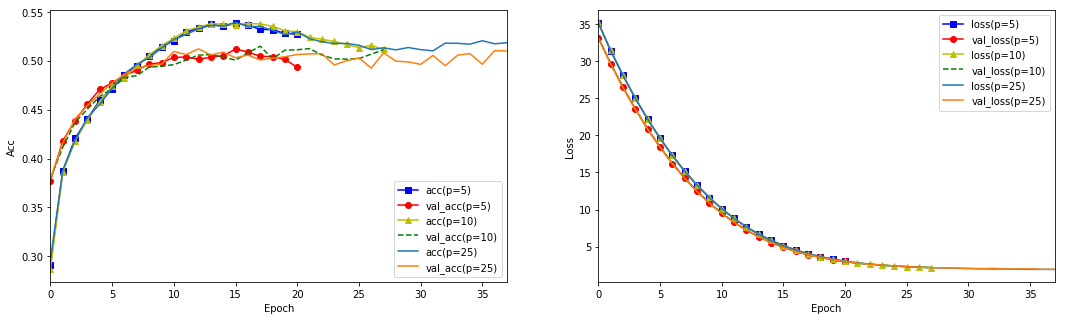

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

df_acc_results, df_loss_results = show_train_history(results)

In [31]:
df_acc_results

,acc(p=5),val_acc(p=5),acc(p=10),val_acc(p=10),acc(p=25),val_acc(p=25)
0,0.29104,0.3774,0.28668,0.3795,0.29674,0.3790
1,0.38744,0.4181,0.38584,0.4115,0.38820,0.4160
2,0.42056,0.4389,0.41806,0.4371,0.41890,0.4406
3,0.44040,0.4559,0.43960,0.4507,0.44194,0.4542
4,0.45972,0.4707,0.45808,0.4634,0.45558,0.4661
5,0.47128,0.4773,0.47374,0.4716,0.47180,0.4774
6,0.48508,0.4846,0.48192,0.4829,0.48666,0.4861
7,0.49474,0.4903,0.49524,0.4848,0.49624,0.4925
8,0.50532,0.4965,0.50572,0.4934,0.50308,0.4951
9,0.51412,0.4981,0.51556,0.4944,0.51298,0.4965


In [32]:
df_loss_results

,loss(p=5),val_loss(p=5),loss(p=10),val_loss(p=10),loss(p=25),val_loss(p=25)
0,35.161049,33.151395,35.217635,33.201700,35.150199,33.146579
1,31.421739,29.653309,31.467823,29.702363,31.414796,29.650338
2,28.064280,26.452835,28.113830,26.501010,28.060822,26.447375
3,24.993379,23.520329,25.040471,23.570577,24.987686,23.515618
4,22.180503,20.838436,22.223095,20.891763,22.172442,20.833220
5,19.614229,18.405362,19.652306,18.451665,19.601271,18.394812
6,17.286866,16.203971,17.325418,16.245484,17.268909,16.187949
7,15.182362,14.220489,15.217487,14.260738,15.163149,14.207569
8,13.291995,12.450650,13.326451,12.485962,13.283523,12.436945
9,11.609344,10.881614,11.637671,10.915159,11.598991,10.869760
